In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, shape
from haversine import haversine, Unit
import pandas as pd
from shapely.geometry import MultiPoint, MultiPolygon
import json
import datetime
from geopy.distance import geodesic
import pyarrow
import json
import matplotlib.pyplot as plt


In [56]:
import pandas as pd

kincaid = pd.read_csv('data/california_jul_nov_2019.csv', engine='pyarrow')
kincaid['date'] = pd.to_datetime(kincaid.date)

pre_fire = kincaid.query('date < "2019-10-23"')
during_fire = kincaid.query('date >= "2019-10-23" and date <= "2019-11-06"')

In [57]:
n_days = (during_fire.date.max() - during_fire.date.min()).days
during_fire = during_fire.groupby(['geoid_o', 'geoid_d']).agg({'visitor_flows':'sum', 'pop_flows':'sum'})
during_fire = during_fire.multiply(1/n_days)
during_fire.reset_index(inplace=True)

# add the latitudes and longtitudes
during_fire = during_fire.merge(kincaid.drop_duplicates(['geoid_o'])[['geoid_o','lat_o','lng_o']] ,how='left', on=['geoid_o']).merge(kincaid.drop_duplicates(['geoid_d'])[['geoid_d','lat_d','lng_d']], how='left', on='geoid_d')

during_fire

,geoid_o,geoid_d,visitor_flows,pop_flows,lat_o,lng_o,lat_d,lng_d
0,6001,6001,143944.000000,3.316598e+06,37.650547,-121.917885,37.650547,-121.917885
1,6001,6003,0.571429,1.257143e+01,37.650547,-121.917885,38.597251,-119.820653
2,6001,6005,28.785714,6.595000e+02,37.650547,-121.917885,38.446390,-120.651116
3,6001,6007,38.714286,8.890714e+02,37.650547,-121.917885,39.666929,-121.600672
4,6001,6009,36.214286,8.310000e+02,37.650547,-121.917885,38.204607,-120.554132
...,...,...,...,...,...,...,...,...
3008,6115,6107,3.357143,5.914286e+01,39.269008,-121.351263,36.220157,-118.800473
3009,6115,6109,0.285714,5.214286e+00,39.269008,-121.351263,38.027601,-119.954753
3010,6115,6111,2.285714,4.000000e+01,39.269008,-121.351263,34.357529,-119.126027
3011,6115,6113,128.214286,2.282143e+03,39.269008,-121.351263,38.686646,-121.901620


In [58]:
df_fire = pd.read_csv('data/ca_daily_fire_2000_03252022.csv')

In [59]:
df_fire = df_fire[df_fire['year']>= 2019]
df_fire = df_fire[df_fire['year']<= 2021]

In [60]:
df_fire

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month
180,32.519249,-114.732300,2021-08-02,N,VIIRS,100,2021,8
184,32.521088,-114.731140,2021-08-02,N,VIIRS,50,2021,8
190,32.525978,-114.735359,2021-08-02,N,VIIRS,50,2021,8
211,32.533710,-114.799103,2020-02-29,N,VIIRS,50,2020,2
225,32.536598,-114.718857,2020-07-15,N,VIIRS,50,2020,7
...,...,...,...,...,...,...,...,...
1116850,41.999905,-123.618187,2020-09-19,N,VIIRS,50,2020,9
1116851,41.999920,-123.597160,2020-09-09,N,VIIRS,50,2020,9
1116852,41.999920,-123.407028,2020-09-10,N,VIIRS,50,2020,9
1116857,41.999950,-123.621155,2020-09-20,N,VIIRS,50,2020,9


In [61]:
# Define coordinates for the three wildfires
czu_lightning_complex_coords = (37.161, -122.208)
kincaid_fire_coords = (38.792458, -122.780053)
august_complex_coords = (39.765, -122.673)

# Define a threshold distance within which a record is considered to belong to a wildfire
threshold_distance = 10

# Compute distance to each wildfire and filter the records based on threshold distance
df_fire_czu = df_fire.copy()
df_fire_czu['dist_to_czu'] = df_fire_czu.apply(lambda row: geodesic((row['latitude'], row['longitude']), czu_lightning_complex_coords).kilometers, axis=1)
df_fire_czu = df_fire_czu[df_fire_czu['dist_to_czu'] <= threshold_distance]

df_fire_kincaid = df_fire.copy()
df_fire_kincaid['dist_to_kincaid'] = df_fire_kincaid.apply(lambda row: geodesic((row['latitude'], row['longitude']), kincaid_fire_coords).kilometers, axis=1)
df_fire_kincaid = df_fire_kincaid[df_fire_kincaid['dist_to_kincaid'] <= threshold_distance]

df_fire_august = df_fire.copy()
df_fire_august['dist_to_august'] = df_fire_august.apply(lambda row: geodesic((row['latitude'], row['longitude']), august_complex_coords).kilometers, axis=1)
df_fire_august = df_fire_august[df_fire_august['dist_to_august'] <= threshold_distance]


In [ ]:
# Convert acq_date to datetime
df_fire_czu['acq_date'] = pd.to_datetime(df_fire_czu['acq_date'])

# Define the date range
start_date = pd.to_datetime('2020-08-16')
end_date = pd.to_datetime('2020-09-22')

# Filter df_fire_czu by date range
df_fire_czu = df_fire_czu[(df_fire_czu['acq_date'] >= start_date) & (df_fire_czu['acq_date'] <= end_date)]


In [ ]:
df_fire_czu

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month,dist_to_czu
291851,37.072762,-122.220879,2020-08-20,N,VIIRS,50,2020,8,9.859307
291865,37.072922,-122.213928,2020-08-19,N,VIIRS,50,2020,8,9.789070
291889,37.073280,-122.202957,2020-08-20,N,VIIRS,50,2020,8,9.745463
291895,37.073452,-122.225166,2020-08-20,N,VIIRS,50,2020,8,9.835111
291916,37.073799,-122.185020,2020-08-20,N,VIIRS,50,2020,8,9.890712
...,...,...,...,...,...,...,...,...,...
311975,37.246353,-122.242752,2020-08-18,N,VIIRS,50,2020,8,9.962318
312025,37.246738,-122.232040,2020-08-19,N,VIIRS,50,2020,8,9.751714
312026,37.246758,-122.225922,2020-08-20,N,VIIRS,50,2020,8,9.649612
312124,37.247456,-122.230240,2020-08-20,N,VIIRS,50,2020,8,9.796030


In [ ]:
# Convert acq_date to datetime
df_fire_kincaid['acq_date'] = pd.to_datetime(df_fire_kincaid['acq_date'])

# Define the date range
start_date = pd.to_datetime('2019-10-23')
end_date = pd.to_datetime('2019-11-06')

# Filter df_fire_czu by date range
df_fire_kincaid = df_fire_kincaid[(df_fire_kincaid['acq_date'] >= start_date) & (df_fire_kincaid['acq_date'] <= end_date)]

In [ ]:
df_fire_kincaid

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month,dist_to_kincaid
503158,38.702831,-122.788895,2019-10-27,N,VIIRS,50,2019,10,9.979201
503289,38.703400,-122.795700,2019-10-27,Aqua,MODIS,100,2019,10,9.979526
503354,38.703690,-122.766930,2019-10-27,N,VIIRS,50,2019,10,9.920012
503361,38.703701,-122.780380,2019-10-24,N,VIIRS,50,2019,10,9.853016
503400,38.703900,-122.790700,2019-10-27,Aqua,MODIS,100,2019,10,9.874359
...,...,...,...,...,...,...,...,...,...
523902,38.813416,-122.795296,2019-10-25,N,VIIRS,50,2019,10,2.676983
523974,38.813847,-122.788582,2019-10-25,N,VIIRS,50,2019,10,2.487332
524032,38.814171,-122.803986,2019-10-25,N,VIIRS,50,2019,10,3.183093
524039,38.814201,-122.805214,2019-10-25,N,VIIRS,50,2019,10,3.256233


In [ ]:
df_fire_august

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month,dist_to_august
632256,39.674961,-122.674744,2020-08-19,N,VIIRS,50,2020,8,9.998082
632411,39.675999,-122.680077,2020-08-19,N,VIIRS,50,2020,8,9.900328
632467,39.676350,-122.662659,2020-08-19,N,VIIRS,50,2020,8,9.882599
632591,39.677067,-122.685539,2020-08-19,N,VIIRS,100,2020,8,9.822153
632631,39.677349,-122.667809,2020-08-19,N,VIIRS,50,2020,8,9.742000
...,...,...,...,...,...,...,...,...,...
670032,39.853210,-122.684624,2020-08-31,N,VIIRS,50,2020,8,9.844492
670046,39.853268,-122.679008,2020-09-01,N,VIIRS,50,2020,9,9.813976
670190,39.853691,-122.683655,2020-09-01,N,VIIRS,50,2020,9,9.889626
670220,39.853798,-122.682449,2020-09-01,N,VIIRS,100,2020,9,9.892474


In [ ]:
df_fire_czu

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month,dist_to_czu
291851,37.072762,-122.220879,2020-08-20,N,VIIRS,50,2020,8,9.859307
291865,37.072922,-122.213928,2020-08-19,N,VIIRS,50,2020,8,9.789070
291889,37.073280,-122.202957,2020-08-20,N,VIIRS,50,2020,8,9.745463
291895,37.073452,-122.225166,2020-08-20,N,VIIRS,50,2020,8,9.835111
291916,37.073799,-122.185020,2020-08-20,N,VIIRS,50,2020,8,9.890712
...,...,...,...,...,...,...,...,...,...
311975,37.246353,-122.242752,2020-08-18,N,VIIRS,50,2020,8,9.962318
312025,37.246738,-122.232040,2020-08-19,N,VIIRS,50,2020,8,9.751714
312026,37.246758,-122.225922,2020-08-20,N,VIIRS,50,2020,8,9.649612
312124,37.247456,-122.230240,2020-08-20,N,VIIRS,50,2020,8,9.796030


In [ ]:
# Convert acq_date to datetime
df_fire_august['acq_date'] = pd.to_datetime(df_fire_august['acq_date'])

# Define the date range
start_date = pd.to_datetime('2020-08-16')
end_date = pd.to_datetime('2020-11-12')

# Filter df_fire_czu by date range
df_fire_august = df_fire_august[(df_fire_august['acq_date'] >= start_date) & (df_fire_august['acq_date'] <= end_date)]

In [ ]:
df_fire_august

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month,dist_to_august
632256,39.674961,-122.674744,2020-08-19,N,VIIRS,50,2020,8,9.998082
632411,39.675999,-122.680077,2020-08-19,N,VIIRS,50,2020,8,9.900328
632467,39.676350,-122.662659,2020-08-19,N,VIIRS,50,2020,8,9.882599
632591,39.677067,-122.685539,2020-08-19,N,VIIRS,100,2020,8,9.822153
632631,39.677349,-122.667809,2020-08-19,N,VIIRS,50,2020,8,9.742000
...,...,...,...,...,...,...,...,...,...
670032,39.853210,-122.684624,2020-08-31,N,VIIRS,50,2020,8,9.844492
670046,39.853268,-122.679008,2020-09-01,N,VIIRS,50,2020,9,9.813976
670190,39.853691,-122.683655,2020-09-01,N,VIIRS,50,2020,9,9.889626
670220,39.853798,-122.682449,2020-09-01,N,VIIRS,100,2020,9,9.892474


In [ ]:
df_fire_kincaid

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month,dist_to_kincaid
503158,38.702831,-122.788895,2019-10-27,N,VIIRS,50,2019,10,9.979201
503289,38.703400,-122.795700,2019-10-27,Aqua,MODIS,100,2019,10,9.979526
503354,38.703690,-122.766930,2019-10-27,N,VIIRS,50,2019,10,9.920012
503361,38.703701,-122.780380,2019-10-24,N,VIIRS,50,2019,10,9.853016
503400,38.703900,-122.790700,2019-10-27,Aqua,MODIS,100,2019,10,9.874359
...,...,...,...,...,...,...,...,...,...
523902,38.813416,-122.795296,2019-10-25,N,VIIRS,50,2019,10,2.676983
523974,38.813847,-122.788582,2019-10-25,N,VIIRS,50,2019,10,2.487332
524032,38.814171,-122.803986,2019-10-25,N,VIIRS,50,2019,10,3.183093
524039,38.814201,-122.805214,2019-10-25,N,VIIRS,50,2019,10,3.256233


In [ ]:
during_fire

,geoid_o,geoid_d,visitor_flows,pop_flows,lat_o,lng_o,lat_d,lng_d
0,6001,6001,143944.000000,3.316598e+06,37.650547,-121.917885,37.650547,-121.917885
1,6001,6003,0.571429,1.257143e+01,37.650547,-121.917885,38.597251,-119.820653
2,6001,6005,28.785714,6.595000e+02,37.650547,-121.917885,38.446390,-120.651116
3,6001,6007,38.714286,8.890714e+02,37.650547,-121.917885,39.666929,-121.600672
4,6001,6009,36.214286,8.310000e+02,37.650547,-121.917885,38.204607,-120.554132
...,...,...,...,...,...,...,...,...
3008,6115,6107,3.357143,5.914286e+01,39.269008,-121.351263,36.220157,-118.800473
3009,6115,6109,0.285714,5.214286e+00,39.269008,-121.351263,38.027601,-119.954753
3010,6115,6111,2.285714,4.000000e+01,39.269008,-121.351263,34.357529,-119.126027
3011,6115,6113,128.214286,2.282143e+03,39.269008,-121.351263,38.686646,-121.901620


In [ ]:
def mark_blocked_paths(df_fire, df_travel, save_path, buffer_radius_km):

    # GeoDataFrame for travel data
    geometry_travel = [LineString([(row['lng_o'], row['lat_o']), (row['lng_d'], row['lat_d'])]) for idx, row in df_travel.iterrows()]
    gdf_travel = gpd.GeoDataFrame(df_travel, geometry=geometry_travel)

    # Set the CRS for the GeoDataFrames
    gdf_travel.set_crs("EPSG:4326", inplace=True)

    # For each unique date in the fire data, create a Polygon (buffered Convex Hull) that encompasses all points for that date
    df_fire['acq_date'] = pd.to_datetime(df_fire['acq_date'])
    unique_dates = df_fire['acq_date'].dt.date.unique()
    fire_polygons = []
    for date in unique_dates:
        df_date = df_fire[df_fire['acq_date'].dt.date == date]
        fire_points = MultiPoint([xy for xy in zip(df_date['longitude'], df_date['latitude'])])
        fire_polygon = gpd.GeoSeries(fire_points.convex_hull, crs="EPSG:4326")  # Create GeoSeries

        # Buffer the polygon
        # First, project the GeoDataFrame to a coordinate system where the unit is meters (e.g., UTM)
        fire_polygon_utm = fire_polygon.to_crs('EPSG:32610')  # Replace 'EPSG:32610' with the correct UTM zone if needed
        buffered_fire_polygon_utm = fire_polygon_utm.buffer(buffer_radius_km * 1000)  # Buffer the polygon in the projected coordinate system

        # Then, project the GeoDataFrame back to WGS84 (latitude/longitude coordinates)
        buffered_fire_polygon = buffered_fire_polygon_utm.to_crs('EPSG:4326')

        fire_polygons.append(buffered_fire_polygon.iloc[0])

    # GeoDataFrame for fire data
    gdf_fire = gpd.GeoDataFrame(df_fire['acq_date'].drop_duplicates().reset_index(drop=True), geometry=fire_polygons)
    gdf_fire.set_crs("EPSG:4326", inplace=True)

    # Save fire polygons as GeoJSON
    gdf_fire.to_file(save_path, driver="GeoJSON")

    print("Sample of gdf_travel before join:")
    print(gdf_travel.head())

    print("Sample of gdf_fire before join:")
    print(gdf_fire.head())

    join_result = gpd.sjoin(gdf_travel, gdf_fire, how="left", op="intersects")

    print("Sample of join_result after join:")
    print(join_result.head())

    blocked_paths = join_result[join_result.index_right.notnull()].index.unique()

    print("Sample of blocked_paths after join:")
    print(blocked_paths[:10])

    df_travel['blocked'] = False
    for path in blocked_paths:
        df_travel.loc[path, 'blocked'] = True

    print("Sample of df_travel after marking blocked paths:")
    print(df_travel.head())

    # Create a DataFrame that pairs counties
    df_pairs = df_travel[['geoid_o', 'geoid_d']].drop_duplicates().sort_values(by=['geoid_o', 'geoid_d']).reset_index(drop=True)
    df_pairs['blocked'] = False  # Initially mark all pairs as not blocked

    # For each blocked path, mark the corresponding pair of counties as blocked
    for path in blocked_paths:
        geoid_o = df_travel.loc[path, 'geoid_o']
        geoid_d = df_travel.loc[path, 'geoid_d']
        df_pairs.loc[(df_pairs['geoid_o'] == geoid_o) & (df_pairs['geoid_d'] == geoid_d), 'blocked'] = True

    print("Sample of df_pairs after marking blocked paths:")
    print(df_pairs.head())

    return df_pairs


In [ ]:
buffer_radius_km = 2  # Specify your desired buffer radius here in kilometers.


In [ ]:

# Apply function for each fire
# df_travel_czu_blocked, blocking_paths_czu = mark_blocked_paths(df_fire_czu, during_fire.copy(), "data/czu_fire_polygons.geojson")
df_travel_kincaid_blocked_pairs = mark_blocked_paths(df_fire_kincaid, during_fire.copy(), "data/kincaid_fire_polygons.geojson", buffer_radius_km)
# df_travel_august_blocked, blocking_paths_august = mark_blocked_paths(df_fire_august, during_fire.copy(), "data/august_fire_polygons.geojson")

Sample of gdf_travel before join:
   geoid_o  geoid_d  visitor_flows     pop_flows      lat_o       lng_o  \
0     6001     6001  143944.000000  3.316598e+06  37.650547 -121.917885   
1     6001     6003       0.571429  1.257143e+01  37.650547 -121.917885   
2     6001     6005      28.785714  6.595000e+02  37.650547 -121.917885   
3     6001     6007      38.714286  8.890714e+02  37.650547 -121.917885   
4     6001     6009      36.214286  8.310000e+02  37.650547 -121.917885   

       lat_d       lng_d                                           geometry  
0  37.650547 -121.917885  LINESTRING (-121.91789 37.65055, -121.91789 37...  
1  38.597251 -119.820653  LINESTRING (-121.91789 37.65055, -119.82065 38...  
2  38.446390 -120.651116  LINESTRING (-121.91789 37.65055, -120.65112 38...  
3  39.666929 -121.600672  LINESTRING (-121.91789 37.65055, -121.60067 39...  
4  38.204607 -120.554132  LINESTRING (-121.91789 37.65055, -120.55413 38...  
Sample of gdf_fire before join:
    acq_date   

/Users/luisquinonespr/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_travel_kincaid_blocked_pairs.blocked.nunique()

2

In [ ]:
df_travel_kincaid_blocked_pairs.blocked.value_counts()

False    2964
True       49
Name: blocked, dtype: int64

In [ ]:
def plot_data(df_fire, df_travel, df_pairs, fire_name):
    # Convert to GeoDataFrames
    geometry_fire = [Point(xy) for xy in zip(df_fire.longitude, df_fire.latitude)]
    gdf_fire = gpd.GeoDataFrame(df_fire, geometry=geometry_fire)

    geometry_travel = [LineString([(row['lng_o'], row['lat_o']), (row['lng_d'], row['lat_d'])]) for idx, row in df_travel.iterrows()]
    gdf_travel = gpd.GeoDataFrame(df_travel, geometry=geometry_travel)
    
    # Merge df_pairs with df_travel to bring back the geometry of the travel paths
    df_pairs_with_geometry = pd.merge(df_pairs, df_travel[['geoid_o', 'geoid_d', 'geometry']], on=['geoid_o', 'geoid_d'], how='left')
    
    df_pairs_blocked = df_pairs_with_geometry[df_pairs_with_geometry['blocked'] == True]
    gdf_travel_blocked = gpd.GeoDataFrame(df_pairs_blocked, geometry=df_pairs_blocked['geometry'])

    # Create plot
    fig, ax = plt.subplots(figsize=(15, 15))
    gdf_travel.plot(ax=ax, color='blue', label='Travel routes', alpha = 0.02)
    gdf_travel_blocked.plot(ax=ax, color='yellow', label='Blocked routes', alpha=0.5)
    gdf_fire.plot(ax=ax, color='red', markersize=100, label='Fire location', alpha=1.0)
    plt.title(f'Fire and blocked paths for {fire_name}')
    plt.legend()
    plt.show()


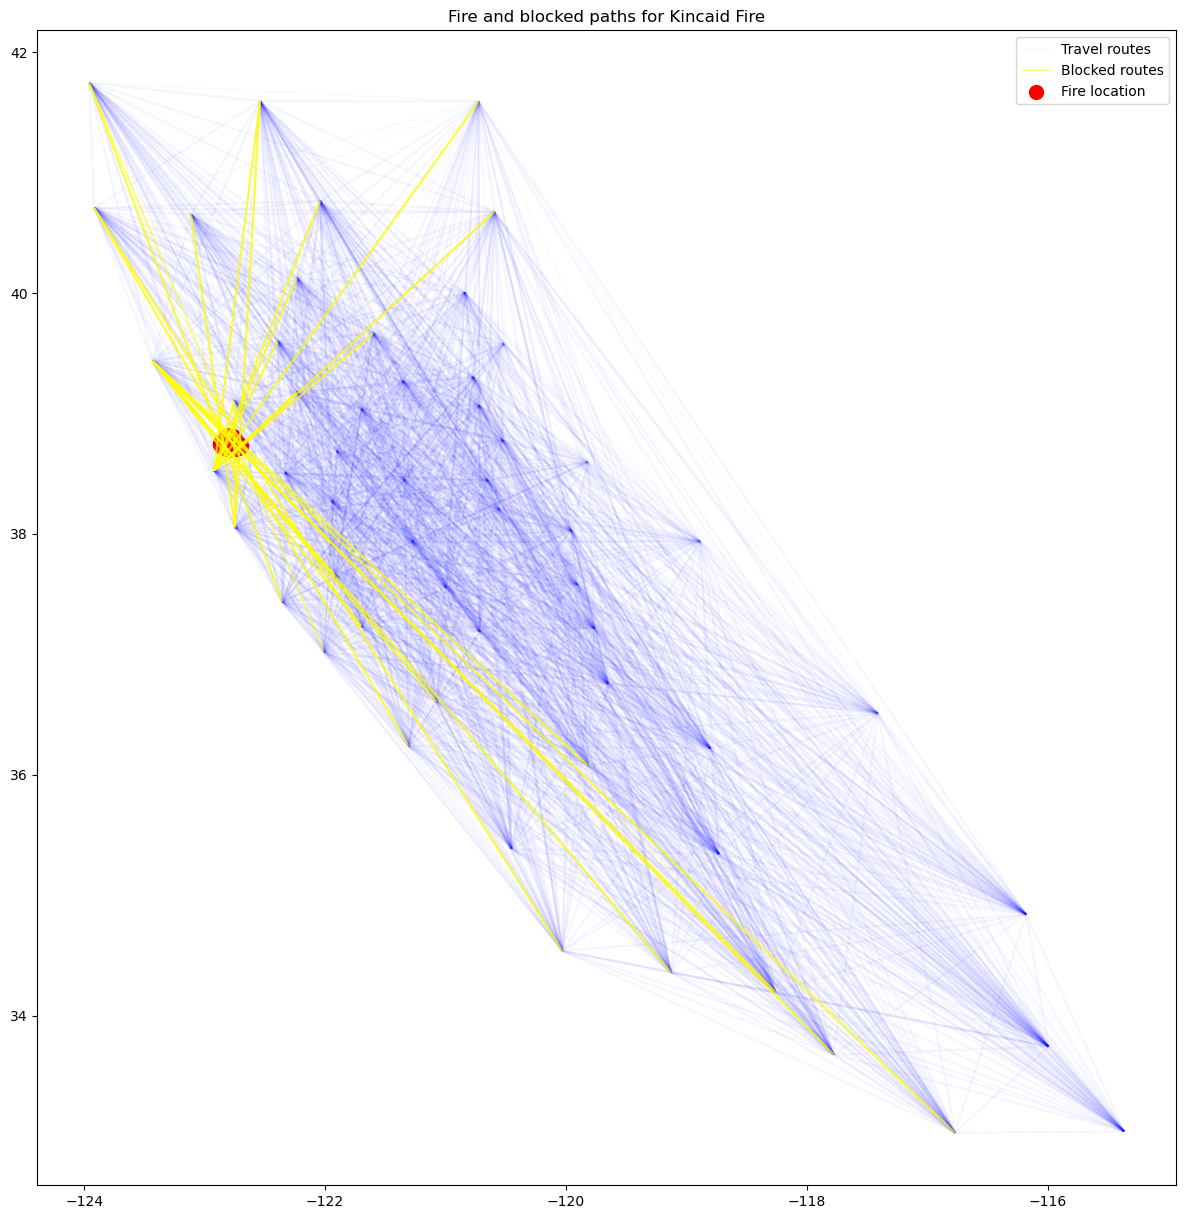

In [ ]:
# Plot for each fire
# plot_data(df_fire_czu, df_travel, df_travel_czu_blocked, 'CZU Fire')
plot_data(df_fire_kincaid, during_fire, df_travel_kincaid_blocked_pairs, 'Kincaid Fire')
# plot_data(df_fire_august, df_travel, df_travel_august_blocked, 'August Fire')

In [ ]:
with open('data/kincaid_fire_polygons.geojson', 'r') as file:
    geojson = json.load(file)

dates = []
areas = []

for feature in geojson['features']:
    # Extract the acquisition date and convert it to a datetime object
    date_str = feature['properties']['acq_date']
    date = datetime.datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%S')
    dates.append(date)
    
    # Calculate the area of the polygon and convert it to square kilometers
    geom = shape(feature['geometry'])
    area = geom.area / 1_000_000  # Convert from square meters to square kilometers
    areas.append(area)


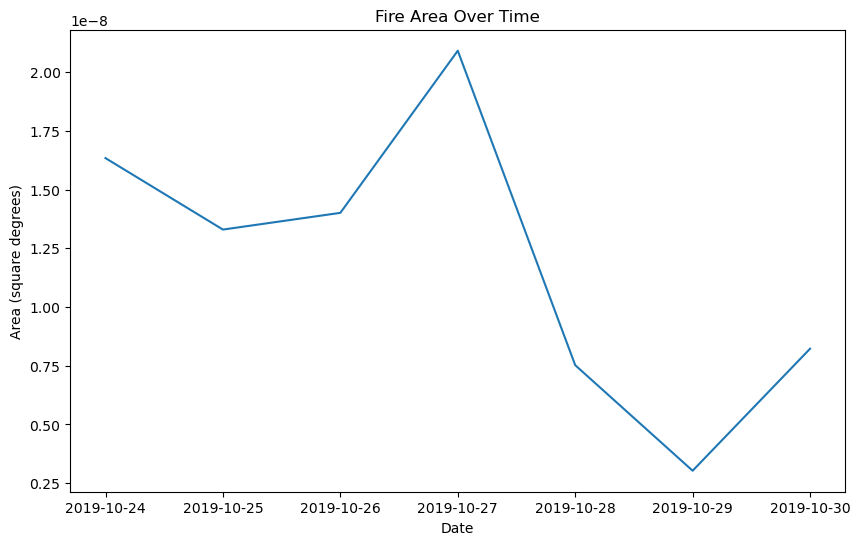

In [ ]:
# Create a DataFrame
df = pd.DataFrame({'Date': dates, 'Area': areas})

# Sort the DataFrame by date
df.sort_values('Date', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Area'])
plt.xlabel('Date')
plt.ylabel('Area (square degrees)')
plt.title('Fire Area Over Time')
plt.show()

In [ ]:
# import networkx as nx

# # Construct a graph from the travel dataframe
# G = nx.from_pandas_edgelist(df_travel_august_blocked, 'lat_o', 'lat_d', create_using=nx.Graph())

# # Get blocked edges from the dataframe
# blocked_edges = df_travel_august_blocked[df_travel_august_blocked['blocked'] == True][['lat_o', 'lat_d']].values

# # Remove blocked edges from the graph
# G.remove_edges_from(blocked_edges)

# # Basic network plot
# nx.draw(G, with_labels=False, node_size=10)

# # Show plot
# plt.show()


In [ ]:
df_travel_kincaid_blocked_pairs